In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # 歸一
])
# print(transform)

# 訓練數劇集
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2) # num_workers線程數

# 測試數據集
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2) # num_workers線程數

Files already downloaded and verified
Files already downloaded and verified


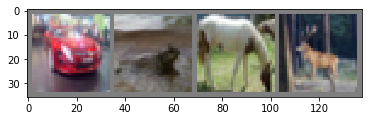

In [3]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def imshow(img):
    # 輸入數據: torch.tensor [c, h, w]
    img = img / 2+0.5
    nping = img.numpy()
    nping = np.transpose(nping, (1, 2, 0)) # [h, w, c]
    plt.imshow(nping)

dataiter = iter(trainloader) # 隨機加載一個mini batch
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self): # 定義神經網路結構, 輸入數據 3x32x32
        super(Net, self).__init__()
        # 第一層(卷基層)
        self.conv1 = nn.Conv2d(3, 6, 3) # 輸入頻道3, 輸出頻道6, 卷積3x3
        # 第二層(卷基層)
        self.conv2 = nn.Conv2d(6, 16, 3) # 輸入頻道6, 輸出頻道16, 卷積3x3
        # 第三層(全連接層)
        self.fc1 = nn.Linear(16*28*28, 512) # 輸入維度16x28x28=12544, 28的原因是經過了兩層神經層,經過一層扣2, 輸出維度512
        # 第四層(全連接層)
        self.fc2 = nn.Linear(512, 64) # 輸入維度512, 輸出維度64
        # 第五層(全連接層)
        self.fc3 = nn.Linear(64, 10) # 輸入維度64, 輸出維度10

    def forward(self, x): # 定義數據流向
        x = self.conv1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = F.relu(x)

        x = x.view(-1, 16*28*28) # view=>重定型
        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = F.relu(x)

        x = self.fc3(x)
        
        return x

In [5]:
net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=12544, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss() # 交叉熵損失函數
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [7]:
for epoch in range(2):
    for i, data in enumerate(trainloader):
        images, labels = data
        outputs = net(images)
        loss = criterion(outputs, labels) # 計算損失

        optimizer.zero_grad() # 梯度前, 首先歸0
        loss.backward()
        optimizer.step()

        if i%1000 == 0:
            print(f'Epoch:{epoch}, Step{i}:, Loss:{loss.item()}')

Epoch:0, Step0:, Loss:2.309619665145874
Epoch:0, Step1000:, Loss:2.3482580184936523
Epoch:0, Step2000:, Loss:2.369257688522339
Epoch:0, Step3000:, Loss:1.5921813249588013
Epoch:0, Step4000:, Loss:1.8849620819091797
Epoch:0, Step5000:, Loss:1.2939252853393555
Epoch:0, Step6000:, Loss:1.9565333127975464
Epoch:0, Step7000:, Loss:0.5908781290054321
Epoch:0, Step8000:, Loss:1.570176362991333
Epoch:0, Step9000:, Loss:1.1008410453796387
Epoch:0, Step10000:, Loss:2.3189361095428467
Epoch:0, Step11000:, Loss:1.1171109676361084
Epoch:0, Step12000:, Loss:0.705569326877594
Epoch:1, Step0:, Loss:2.284975051879883
Epoch:1, Step1000:, Loss:1.2989695072174072
Epoch:1, Step2000:, Loss:1.3752851486206055
Epoch:1, Step3000:, Loss:1.1618404388427734
Epoch:1, Step4000:, Loss:0.929723858833313
Epoch:1, Step5000:, Loss:1.8677445650100708
Epoch:1, Step6000:, Loss:1.4655733108520508
Epoch:1, Step7000:, Loss:0.2776573896408081
Epoch:1, Step8000:, Loss:1.881150722503662
Epoch:1, Step9000:, Loss:1.434006929397583

In [8]:
# 測試模型

correct = 0.0
total = 0.0

with torch.no_grad():
    for data in testloader:
        images, labels = data

        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)

        correct += (predicted == labels).sum()
        total += labels.size(0)

print('Accuracy:', float(correct)/total)

Accuracy: 0.5688


In [9]:
# 保存模型
torch.save(net.state_dict(), './model.pt')

In [10]:
# 讀取模型
net_2 = Net() # 證明是新的隨機取樣

correct = 0.0
total = 0.0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net_2(images)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum()
        total += labels.size(0)
print('Accuracy:', float(correct)/total)

Accuracy: 0.0999


In [11]:
net_2.load_state_dict(torch.load('./model.pt'))

<All keys matched successfully>

In [12]:
correct = 0.0
total = 0.0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net_2(images)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum()
        total += labels.size(0)
print('Accuracy:', float(correct)/total)

Accuracy: 0.5688
